In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import clip
import re
import time
import yaml
import os
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN, SCLIPNN3
from utils import EmbeddingsDataset, get_models_to_train

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model.eval()

Loading Models


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [3]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

In [39]:
def get_files_paths(directory):
    train_txt = 'train_sentences.txt'    
    valid_txt = 'valid_sentences.txt'
    train_path = os.path.join(directory,train_txt)    
    valid_path = os.path.join(directory,valid_txt)
    return train_path, valid_path
    
def get_sentences_from_file(filename):
    sentences = []
    with open(filename, mode='rt', encoding='utf-8') as file_object:
        for line in file_object:
            sentences.append(line)    
    return sentences

def regexification(sentences):
    regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
    for r in regex:
        sentences = list(map(lambda sentence: re.sub(r, " ", sentence), sentences))
    return sentences

def get_clip_embeddings_old(sentences, batch_size=32):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings = clip_model.encode_text(tokenized_text)
    return clip_embeddings

def get_clip_embeddings(sentences, batch_size=16):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings_list = []
        for i in range(0,tokenized_text.size()[0],batch_size):
            tok_batch = tokenized_text[i:i+batch_size]
            clip_embeddings_batch = clip_model.encode_text(tok_batch).to(device)
            clip_embeddings_list.append(clip_embeddings_batch)
    final_emb = torch.stack(clip_embeddings_list).view(-1,512)
    return final_emb

def get_sbert_embeddings(sentences):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

def show_embeddings_return_size(sentences, clip_embeddings, sbert_embeddings):
    ("-"*10)
    for sentence, clip_embedding, sbert_embedding in zip(sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
        print("Sentence:", sentence)
        input_size = sbert_embedding.size()[0]    
        print("Sbert Embedding: ", input_size)
        print("Clip Embedding: ", clip_embedding.size()[0])
        print("-"*10)
    return input_size

In [5]:
def show_plot(models,model_train_losses,model_valid_losses):
    rows = 2
    columns = int((len(models)+1)/2)
    fig, axs = plt.subplots(rows,columns,figsize=(18,10))
    positions = []
    for r in range(rows):
        for c in range(columns):
            positions.append((r,c))
    for i, (name, model) in enumerate(models.items()):
        axs[positions[i]].plot(model_train_losses[i][1:], label = 'train '+ name)
        axs[positions[i]].plot(model_valid_losses[i][1:], label = 'valid '+ name, marker = '*')
        axs[positions[i]].set_title('Losses of '+ name)
        axs[positions[i]].grid()
        axs[positions[i]].legend()
    
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Loss')
    
    #fig.legend()
    #fig.title('Losses per Epoch')
    
    plt.show()

In [6]:
def train(model, train_dataset, valid_dataset, b_size=32, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)
        train_counter = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()         
            train_counter += 1
        train_losses.append(train_loss/train_counter)
        
        valid_loss = 0.0
        model.eval()
        valid_counter = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            target = model(inputs)
            loss = criterion(target.to(float), labels.to(float))
            valid_loss += loss.item()
            valid_counter += 1
        valid_losses.append(valid_loss/valid_counter)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Train Loss: {}. Valid Loss: {}".format(epoch, train_loss/train_counter, valid_loss/valid_counter))
    return train_losses, valid_losses

In [7]:
def supra_training(models,train_sbert_emb,train_clip_emb,valid_sbert_emb, valid_clip_emb, trainset):
    model_train_losses = []
    model_valid_losses = []
    final_loss = []
    training_time = []
    for name, model in models.items():
        start_time = time.time()
        train_dataset = EmbeddingsDataset(train_sbert_emb, train_clip_emb)
        valid_dataset = EmbeddingsDataset(valid_sbert_emb, valid_clip_emb)
        train_loss, valid_loss = train(model, train_dataset, valid_dataset)
        torch.save(model.state_dict(), os.path.join('models',trainset + '_' + name + '.pt'))
        model_train_losses.append(train_loss)                   
        model_valid_losses.append(valid_loss)
        final_loss.append(round(valid_loss[-1],3))
        end_time = time.gmtime(time.time() - start_time)
        elapsed_time = time.strftime("%H:%M:%S", end_time)
        training_time.append(elapsed_time)
        print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
        #print("-"*50)        
    actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
    print("End of Training Process on {}".format(actual_time))
    return model_train_losses, model_valid_losses, training_time, final_loss

In [8]:
def get_train_embeddings(directory):
    train_file, valid_file = get_files_paths(directory)
    train_sentences = regexification(get_sentences_from_file(train_file))
    valid_sentences = regexification(get_sentences_from_file(valid_file))
    print("CLIP encoding...")
    train_clip_embeddings = get_clip_embeddings(train_sentences)
    valid_clip_embeddings = get_clip_embeddings(valid_sentences)
    print("SBERT encoding...")
    train_sbert_embeddings = get_sbert_embeddings(train_sentences)
    valid_sbert_embeddings = get_sbert_embeddings(valid_sentences)
    return train_clip_embeddings, valid_clip_embeddings, train_sbert_embeddings, valid_sbert_embeddings

CLIP encoding...
Start 0 and i 0
Start 16 and i 16
Start 32 and i 32
Start 48 and i 48
Start 64 and i 64
Start 80 and i 80
Start 96 and i 96
Start 112 and i 112
Start 128 and i 128
Start 144 and i 144
Start 160 and i 160
Start 176 and i 176
Start 192 and i 192
Start 208 and i 208
Start 224 and i 224
Start 240 and i 240
Start 256 and i 256
Start 272 and i 272
Start 288 and i 288
Start 304 and i 304
Start 320 and i 320
Start 336 and i 336
Start 352 and i 352
Start 368 and i 368
Start 384 and i 384
Start 400 and i 400
Start 416 and i 416
Start 432 and i 432
Start 448 and i 448
Start 464 and i 464
Start 480 and i 480
Start 496 and i 496
Start 512 and i 512
Start 528 and i 528
Start 544 and i 544
Start 560 and i 560
Start 576 and i 576
Start 592 and i 592
Start 608 and i 608
Start 624 and i 624
Start 640 and i 640
Start 656 and i 656
Start 672 and i 672
Start 688 and i 688
Start 704 and i 704
Start 720 and i 720
Start 736 and i 736
Start 752 and i 752
Start 768 and i 768
Start 784 and i 784

,TrainLoss,ValidLoss
NN_700,0.045994,0.047
NN3_700,0.046064,0.047
NN_800,0.046002,0.047
NN3_800,0.046001,0.047


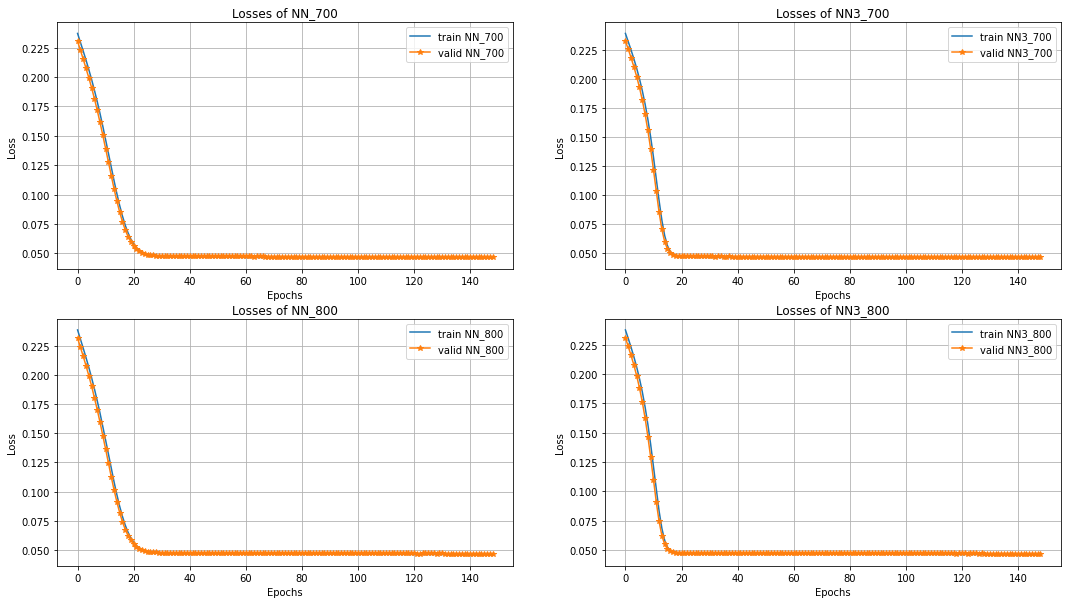

In [40]:
### Training Pipeline
durations = {}
finals = {}
model_dict = {}
directory = 'europarl'
train_clip_emb, valid_clip_emb, train_sbert_emb, valid_sbert_emb = get_train_embeddings(directory)
input_size = train_sbert_emb[0].size()[0]
model_dict[directory] = get_models_to_train(input_size)
print(f'Training on {directory} dataset')
print("Train sbert_ emb : {}".format(train_sbert_emb.size()))
print("Train clip emb: {}".format(train_clip_emb.size()))
train_losses, valid_losses, train_time,final_loss = supra_training(model_dict[directory],train_sbert_emb,train_clip_emb, valid_sbert_emb, valid_clip_emb,trainset=directory)
durations[directory] = train_time
finals[directory] = final_loss
train_final_losses = [x[-1] for x in train_losses]
train_results = pd.DataFrame({"TrainLoss":train_final_losses, "ValidLoss":final_loss}, index=model_dict[directory].keys())
display(train_results)
show_plot(model_dict[directory],train_losses,valid_losses)

In [ ]:
x = torch.empty(3,3)
for i in range(3):
    y = torch.FloatTensor([[1,2,3],[4,5,6]])
    x = torch.cat([x, y], dim=0)
print(x)
x.size()

In [ ]:
x = torch.empty(2,3)

torch.Size([8, 3])

In [30]:
sentences = ["this is a sentence for trying","segunda oración","lets go for a third one","más frases","para hacer esto más largo", "and i do not know"]

In [31]:
clip_emb = get_clip_embeddings(sentences)
clip_emb.size()

torch.Size([6, 77])
tokenized text 1: 6


torch.Size([6, 512])

In [32]:
def get_clip_embeddings_copy(sentences, batch_size=2):
    tokenized_text = clip.tokenize(sentences).to(device)
    print(tokenized_text.size())
    with torch.no_grad():
        clip_embeddings_list = []
        start = 0
        print(f'tokenized text 1: {tokenized_text.size()[0]}')
        for i in range(0,tokenized_text.size()[0],batch_size):
            tok_batch = tokenized_text[start:start+batch_size]
            clip_embeddings_batch = clip_model.encode_text(tok_batch).to(device)
            if i == 0:
                emb_size = clip_embeddings_batch.size()[1]
            clip_embeddings_list.append(clip_embeddings_batch)
            start += 1
    final_emb = torch.stack(clip_embeddings_list).view(len(sentences),emb_size)
    return final_emb

In [33]:
clip_emb_copy = get_clip_embeddings_copy(sentences)
clip_emb_copy.size()

torch.Size([6, 77])
tokenized text 1: 6


torch.Size([6, 512])